In [ ]:
!git clone https://github.com/yappy2000d/niicc2024.git --recursive
!mv ./niicc2024/* .
!rm -rf ./niicc2024

fatal: destination path 'niicc2024' already exists and is not an empty directory.


In [33]:
from collections import Counter
import csv, os, time, shutil
import threading

from yolov5.detect import run


folder_path = "ROOT/exp/labels/"
file_path = folder_path + "original.txt"
id2classname = ['lettuce', 'potato', 'carrot', 'onion', 'garlic', 'leek', 'broccoli']

def myprocess():

    run(weights='yolov5/runs/train/yolo_veg_det/weights/best.pt',
        source='./original.jpg',
        conf_thres=0.25, project='ROOT',
        save_txt=True
    )

    reserve = [0] * len(id2classname)

    while not os.path.exists(folder_path):
        time.sleep(1)

    if not os.path.exists(file_path):
        # 無辨識到
        pass
    else:
        with open(file_path, newline='') as file:
            rows = csv.reader(file, delimiter=' ')
            result = [row[0] for row in rows]

            for id in result:
                reserve[int(id)] += 1

            counter = Counter(result)
            reserve = [0] * len(id2classname)
            for id, count in counter.items():
                reserve[int(id)] = count

    print(dict(zip(id2classname, reserve)))
    shutil.rmtree("ROOT")

## 做一點處理使colab能讀取視訊
參考資料來源：

[![](https://img.shields.io/badge/Medium-@Jack_omnixri-blue?logo=medium&logoColor=f5f5f5)](https://omnixri.medium.com/%E5%A6%82%E4%BD%95%E5%9C%A8google-colab%E4%B8%8A%E4%BD%BF%E7%94%A8%E6%9C%AC%E5%9C%B0%E7%AB%AFwebcam%E5%8D%B3%E6%99%82%E9%81%8B%E8%A1%8Copencv%E8%87%AA%E5%AE%9A%E7%BE%A9%E5%BD%B1%E5%83%8F%E8%99%95%E7%90%86%E5%87%BD%E5%BC%8F-9870d59c676)
[![](https://img.shields.io/badge/Github-OmniXRI/Colab_Webcam_OpenCV-blue?logo=github&logoColor=f5f5f5)](https://github.com/OmniXRI/Colab_Webcam_OpenCV)

In [15]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
from google.colab.patches import cv2_imshow

In [16]:
def js_to_image(js_reply):
  # 解碼成 base64 格式影像
  image_bytes = b64decode(js_reply.split(',')[1])
  # 轉換影像變成 Numpy 格式
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # 解碼 Numpy格式到 OpenCV BGR 影像格式
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [26]:
def take_photo(filename='', quality=1):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # 取得JavaScript產生的影像物件
  data = eval_js('takePhoto({})'.format(quality))

  # 取得影像並加入自定義之OpenCV影像處理程式
  img = js_to_image(data)
  cv2.imwrite("original.jpg", img)
  result_img = myprocess()

  return img

## 主程式


<IPython.core.display.Javascript object>

{'lettuce': 0, 'potato': 0, 'carrot': 0, 'onion': 4, 'garlic': 0, 'leek': 0, 'broccoli': 0}


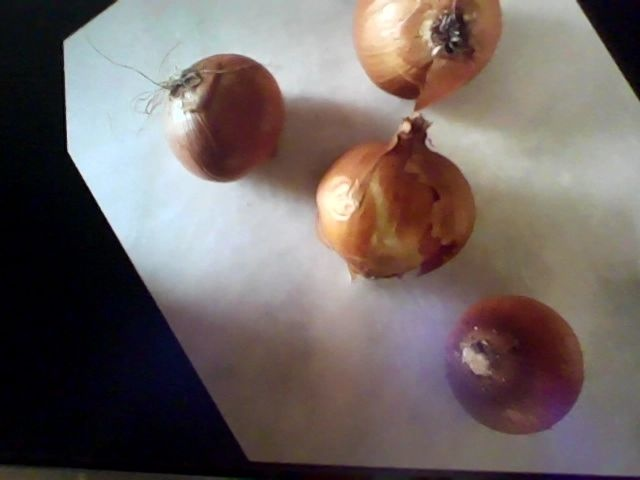

In [34]:
#from IPython.display import Image
try:
  # 啟動網路攝影機連續取像，按下「Capture」後，取得靜態影像，經自定義影像處理後並顯示，預設存檔檔名 photo.jpg
  take_photo()

  # 顯示網路攝影機取得之原始影像
  original_filename = 'original.jpg'
  display(Image(original_filename))

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))